# Laborator 6

Acest notebook contine rezolvarea celor trei subprobleme din tema de laborator:
1. Regresie liniara pentru scorul fericirii folosind PIB si libertate (Gradient Descent pe batch-uri)
2. Clasificare mamografie (regresie logistica)
3. Clasificare Iris (regresie logistica)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8')
np.random.seed(42)

## Problema 1:
Regresie liniara pentru scorul fericirii folosind PIB si libertate (Gradient Descent pe batch-uri)

#### Pregatire date

In [2]:
df = pd.read_csv("data/world-happiness-report-2017.csv")

df = df[["Economy..GDP.per.Capita.", "Freedom", "Happiness.Score"]].dropna()

df.columns = ["GDP", "Freedom", "Happiness"]

scaler = StandardScaler()
X = scaler.fit_transform(df[["GDP", "Freedom"]])
y = df["Happiness"].values

#### Functii pentru loss, predictie si gradient

In [3]:
def predict(X, w):
    return X @ w

def compute_loss(X, y, w):
    y_pred = predict(X, w)
    return np.mean((y_pred - y) ** 2)

def compute_gradient(X, y, w):
    y_pred = predict(X, w)
    return 2 / len(y) * X.T @ (y_pred - y)

#### Gradient Descent pe batch-uri

In [4]:
# Adaugam coloana de 1 pentru bias
X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

# Parametri
epochs = 200
learning_rate = 0.1
batch_size = 16

# Initializare greutati
w = np.random.randn(X_bias.shape[1])
losses = []

# Gradient Descent pe batch-uri
for epoch in range(epochs):
    indices = np.random.permutation(len(X_bias))
    X_shuffled = X_bias[indices]
    y_shuffled = y[indices]

    for i in range(0, len(X_bias), batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        grad = compute_gradient(X_batch, y_batch, w)
        w -= learning_rate * grad

    loss = compute_loss(X_bias, y, w)
    losses.append(loss)

print("Coeficienti invatati (w):", w)

Coeficienti invatati (w): [5.3716421  0.73460149 0.34246262]


#### Afișarea funcției cost

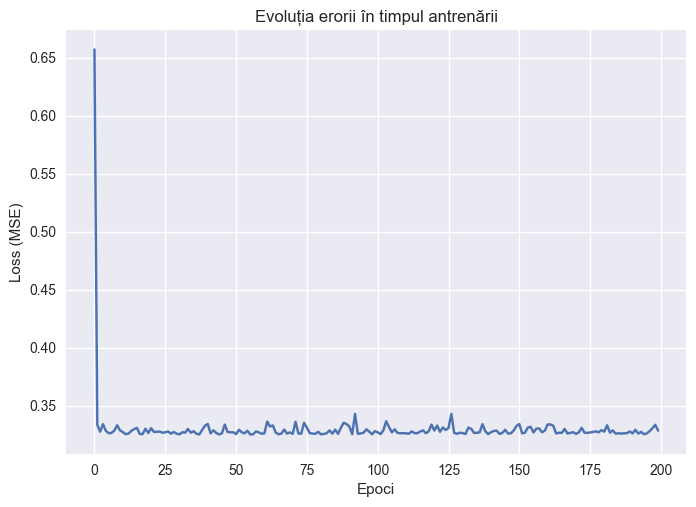

In [5]:
plt.plot(losses)
plt.xlabel("Epoci")
plt.ylabel("Loss (MSE)")
plt.title("Evoluția erorii în timpul antrenării")
plt.grid(True)
plt.show()

#### Comparare cu modelul din sklearn

In [6]:
reg = LinearRegression()
reg.fit(X, y)

sklearn_weights = [float(round(reg.intercept_, 4))] + [float(round(c, 4)) for c in reg.coef_]
manual_weights = [float(round(wi, 4)) for wi in w]

print("Coeficienți sklearn:", sklearn_weights)
print("Coeficienți învățați manual:", manual_weights)

Coeficienți sklearn: [5.354, 0.7858, 0.3522]
Coeficienți învățați manual: [5.3716, 0.7346, 0.3425]


## Problema 2:
Clasificare mamografie (regresie logistica)

#### Pregatire date + normalizare

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Citim fișierul local
file_path = "data/wdbc.data"

columns = ["id", "diagnosis"] + [
    f"{feat}_{stat}" for stat in ["mean", "se", "worst"]
    for feat in [
        "radius", "texture", "perimeter", "area", "smoothness",
        "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"
    ]
]

df = pd.read_csv(file_path, header=None, names=columns)
df["diagnosis"] = df["diagnosis"].map({"B": 0, "M": 1})

X = df[["texture_mean", "radius_mean"]].values
y = df["diagnosis"].values

# Normalizare
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Clasificare folosind sklearn

In [8]:
# Împărțim în train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Antrenăm modelul
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Evaluare
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Acuratețe cu tool (sklearn): {acc:.4f}")

# Clasificare pacient nou
new_point = np.array([[10, 18]])
new_scaled = scaler.transform(new_point)
pred_class = logreg.predict(new_scaled)[0]
pred_proba = logreg.predict_proba(new_scaled)[0]

print("\n🔍 Clasificare pacient nou (tool):")
print(f" Clasă: {'Malign' if pred_class == 1 else 'Benign'}")
print(f" Probabilitate benign: {pred_proba[0]:.4f}, malign: {pred_proba[1]:.4f}")

Acuratețe cu tool (sklearn): 0.9035

🔍 Clasificare pacient nou (tool):
 Clasă: Malign
 Probabilitate benign: 0.3151, malign: 0.6849


#### Functii pt regresie logistica

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_proba(X, w):
    return sigmoid(X @ w)

def predict_class(X, w):
    return (predict_proba(X, w) >= 0.5).astype(int)

def compute_loss(X, y, w):
    y_pred = predict_proba(X, w)
    epsilon = 1e-8
    return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))

def compute_gradient(X, y, w):
    y_pred = predict_proba(X, w)
    return X.T @ (y_pred - y) / len(y)

#### Antrenare cu gradient descendent

In [10]:
# Adăugăm bias (1) la X_scaled
X_bias = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# Inițializare
epochs = 1000
learning_rate = 0.1
w = np.zeros(X_bias.shape[1])
losses = []

# Antrenare
for epoch in range(epochs):
    grad = compute_gradient(X_bias, y, w)
    w -= learning_rate * grad
    losses.append(compute_loss(X_bias, y, w))

print("Coeficienți învățați (cod propriu):", [float(round(wi, 4)) for wi in w])

Coeficienți învățați (cod propriu): [-0.6998, 0.8879, 3.3461]


#### Evolutie fuctie cost

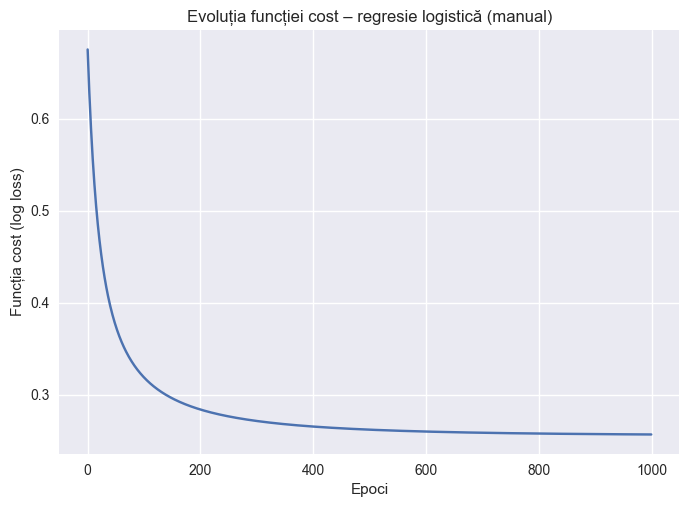

In [11]:
plt.plot(losses)
plt.xlabel("Epoci")
plt.ylabel("Funcția cost (log loss)")
plt.title("Evoluția funcției cost – regresie logistică (manual)")
plt.grid(True)
plt.show()

#### Evaluare + predictie pacient nou

In [12]:
# Acuratețe pe tot setul
y_pred_manual = predict_class(X_bias, w)
acc_manual = accuracy_score(y, y_pred_manual)
print(f"Acuratețe (cod propriu): {acc_manual:.4f}")

# Pacient nou: textura = 10, raza = 18
new_scaled = scaler.transform(np.array([[10, 18]]))
new_bias = np.hstack([[1], new_scaled[0]])
new_pred = predict_class([new_bias], w)[0]
new_proba = predict_proba([new_bias], w)[0]

print("\n🔍 Clasificare pacient nou (cod propriu):")
print(f" Clasă: {'Malign' if new_pred == 1 else 'Benign'}")
print(f" Probabilitate: {new_proba:.4f}")

Acuratețe (cod propriu): 0.8910

🔍 Clasificare pacient nou (cod propriu):
 Clasă: Malign
 Probabilitate: 0.7429


## Problema 3:
Clasificare Iris (regresie logistica)

#### Pregatire date + normalizare

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Încărcare set iris
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

# Filtrăm doar Setosa (0) și Versicolor (1)
mask = y < 2
X = X[mask]
y = y[mask]

# Folosim doar petal length și petal width (coloanele 2 și 3)
X = X[:, [2, 3]]

# Normalizare
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Clasificare cu sklearn

In [14]:
# Împărțim în train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Antrenare
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Evaluare
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Acuratețe (tool - sklearn): {acc:.4f}")

# Predicție pe o floare nouă
new = np.array([[5.0, 1.5]])
new_scaled = scaler.transform(new)
pred = clf.predict(new_scaled)[0]
proba = clf.predict_proba(new_scaled)[0]

print("\n🔍 Clasificare floare nouă (tool):")
print(f" Clasă: {target_names[pred]}")
print(f" Probabilitate: Setosa = {proba[0]:.4f}, Versicolor = {proba[1]:.4f}")

Acuratețe (tool - sklearn): 1.0000

🔍 Clasificare floare nouă (tool):
 Clasă: versicolor
 Probabilitate: Setosa = 0.0028, Versicolor = 0.9972


#### Functii pentru regresie logistica

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_proba(X, w):
    return sigmoid(X @ w)

def predict_class(X, w):
    return (predict_proba(X, w) >= 0.5).astype(int)

def compute_loss(X, y, w):
    y_pred = predict_proba(X, w)
    epsilon = 1e-8
    return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))

def compute_gradient(X, y, w):
    y_pred = predict_proba(X, w)
    return X.T @ (y_pred - y) / len(y)

#### Antrenare cu gradient descendent

In [16]:
# Adăugăm bias
X_bias = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# Inițializare
epochs = 1000
learning_rate = 0.1
w = np.zeros(X_bias.shape[1])
losses = []

# Optimizare
for epoch in range(epochs):
    grad = compute_gradient(X_bias, y, w)
    w -= learning_rate * grad
    losses.append(compute_loss(X_bias, y, w))

print("Coeficienți învățați (cod propriu):", [float(round(wi, 4)) for wi in w])

Coeficienți învățați (cod propriu): [0.3802, 2.8823, 2.8042]


#### Functie de cost:

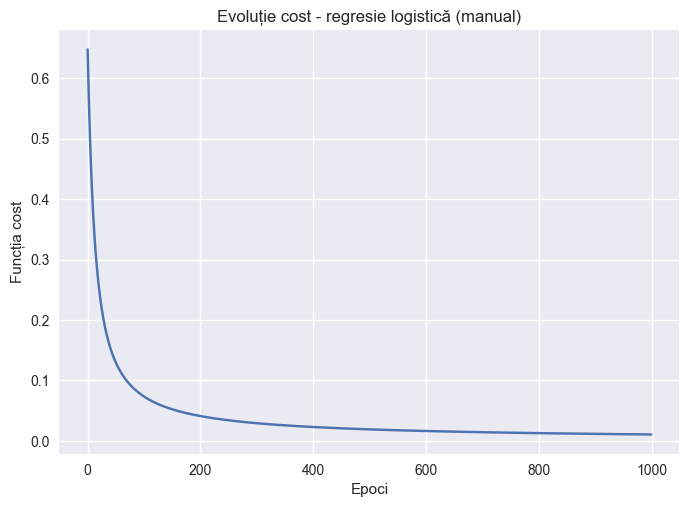

In [17]:
plt.plot(losses)
plt.xlabel("Epoci")
plt.ylabel("Funcția cost")
plt.title("Evoluție cost - regresie logistică (manual)")
plt.grid(True)
plt.show()

#### Evaluare + floare noua

In [18]:
# Evaluare generală
y_pred_manual = predict_class(X_bias, w)
acc_manual = accuracy_score(y, y_pred_manual)
print(f"Acuratețe (cod propriu): {acc_manual:.4f}")

# Clasificăm o floare nouă: petală 5.0 x 1.5
new_scaled = scaler.transform(np.array([[5.0, 1.5]]))
new_bias = np.hstack([[1], new_scaled[0]])
new_pred = predict_class([new_bias], w)[0]
new_proba = predict_proba([new_bias], w)[0]

print("\n🔍 Clasificare floare nouă (cod propriu):")
print(f" Clasă: {target_names[new_pred]}")
print(f" Probabilitate Versicolor: {new_proba:.4f}")

Acuratețe (cod propriu): 1.0000

🔍 Clasificare floare nouă (cod propriu):
 Clasă: versicolor
 Probabilitate Versicolor: 0.9997
